# Milestone Project 2: SkimLit

The puspose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251


## Confirm acccess to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f0f6d360-f50d-76eb-f846-d6b1b257b2d5)


## Get the data

Since we'll be replacing the paper above (PubMed 200k RCT), let's download the dataset they use.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 20.79 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data
Now we've got some text data, it's time to become one with it.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.
  Returns:
    A list of string with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think out data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
   'total_lines: 11},
   ...]
```
Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads if contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Lopp through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # Check to see if it is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (starting from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))


180040 30212 30135
CPU times: user 416 ms, sys: 75.2 ms, total: 492 ms
Wall time: 491 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labes in training data
train_df.target.value_counts()


METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

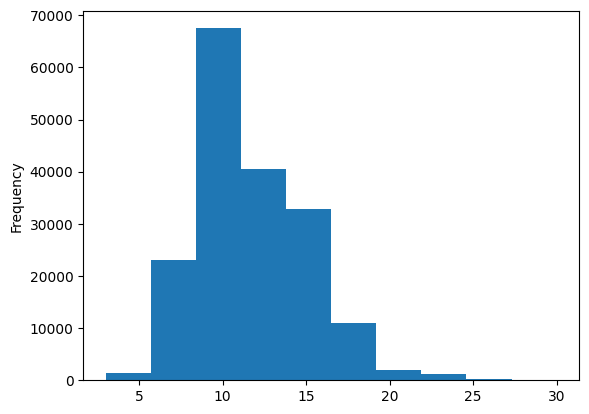

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# Conver abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

## Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

NameError: ignored

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modeling experiments....

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper functions script

In [ ]:
!wget https://raw.githubusercontent.com/UdityaRaj11/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-01 19:13:41--  https://raw.githubusercontent.com/UdityaRaj11/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-01 19:13:41 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentences.split()) for sentences in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

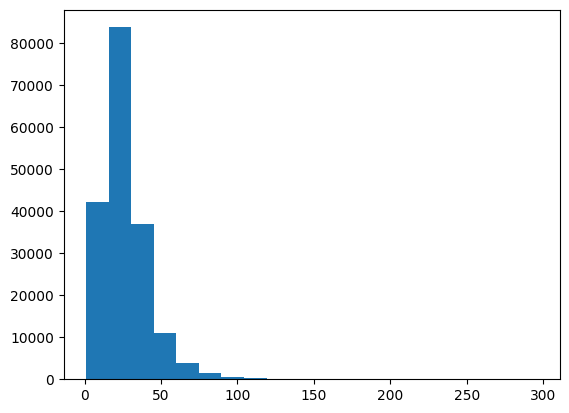

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequences length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [ ]:
# How many words are in our vocab?
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
insecticide-treated nets ( itns ) have proven instrumental in the successful reduction of malaria incidence in holoendemic regions during the past decade .

Length of text: 23

Vectorized text: [[18578  9633 14845    99  2422  4322     5     2   845   169     4  1221
    214     5 56028  1853    52     2  2011  7550     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most comman words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least comman words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most comman words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least comman words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # Length of vocabulary
                               output_dim=128,
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name="token_embedding")

In [ ]:
from pandas._libs.tslibs import vectorized
# show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding): \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 insecticide-treated nets ( itns ) have proven instrumental in the successful reduction of malaria incidence in holoendemic regions during the past decade .

Sentence after vectorization (before embedding): 
 [[18578  9633 14845    99  2422  4322     5     2   845   169     4  1221
    214     5 56028  1853    52     2  2011  7550     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.01482249  0.03476772  0.04149986 ... -0.04289299 -0.0351739
   -0.03785279]
  [ 0.03170396 -0.0493376   0.02853698 ... -0.02587956 -0.0427004
    0.00524156]
  [-0.02080956 -0.00861237  0.00642486 ... -0.01306514 -0.00369632
    0.03969565]
  ...
  [ 0.02802994  0.04005129 -0.03396549 ...  0.00725295  0.01190878
    0.02962602]
  [ 0.02802994  0.04005129 -0.03396549 ...  0.00725295

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the tensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Con1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 55s 78ms/step - loss: 0.9076 - accuracy: 0.6430 - val_loss: 0.6756 - val_accuracy: 0.7420
Epoch 2/3
562/562 [==============================] - 12s 22ms/step - loss: 0.6529 - accuracy: 0.7591 - val_loss: 0.6306 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.6158 - accuracy: 0.7732 - val_loss: 0.5950 - val_accuracy: 0.7829


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5968 - accuracy: 0.7875


[0.5967522859573364, 0.7875016331672668]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 4s 4ms/step


(array([[4.60085839e-01, 1.30155936e-01, 5.83026260e-02, 3.27439487e-01,
         2.40160991e-02],
        [4.37159091e-01, 3.07663620e-01, 1.78269912e-02, 2.27142110e-01,
         1.02082733e-02],
        [2.05440715e-01, 5.96781960e-03, 2.80820113e-03, 7.85751224e-01,
         3.20577565e-05],
        ...,
        [1.15278535e-05, 4.40137752e-04, 8.86091380e-04, 6.61468948e-06,
         9.98655558e-01],
        [5.54484576e-02, 4.95724410e-01, 7.58073926e-02, 6.03875630e-02,
         3.12632143e-01],
        [1.19829990e-01, 7.51642466e-01, 4.72395085e-02, 3.90511565e-02,
         4.22368683e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 result
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

In [ ]:
model_1_results

{'accuracy': 78.75016549715345,
 'precision': 0.7843432535740068,
 'recall': 0.7875016549715345,
 'f1': 0.7852695187158149}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder.

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 failure of the study drug predicted the need for rescue drug therapy in the initial @ hours after discharge from the recovery room ( difference success versus failure = -@ % , @ % ci difference -@ % to -@ % , p = @ ) but not during the period @ to @ hours after discharge from the recovery room ( difference success versus failure = -@ % , @ % ci difference -@ % -@ % , p = @ ) .
Sentence after embedding:
 [-2.1779841e-02 -7.2987601e-02  2.2555949e-02 -3.5358187e-02
  1.5489107e-02  2.9689305e-02  6.7801416e-02 -2.0015668e-02
  6.5347023e-02  5.2750863e-02  4.8680510e-02  6.1997950e-02
  7.6832664e-05  1.7802134e-02  2.6243066e-02 -3.8071595e-02
 -6.1422788e-02  4.3596532e-02 -4.2231979e-05  1.5077382e-02
  3.2260180e-02  5.2327737e-02  1.3051477e-03 -4.0626213e-02
  3.8814552e-02  6.4269546e-03  1.2570442e-02 -1.7116105e-02
 -4.7047690e-02 -5.8345094e-02]

Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embedding TensorFlow Hub

In [ ]:
# Define feature extraction model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs,
                         outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 18ms/step - loss: 0.9169 - accuracy: 0.6509 - val_loss: 0.7963 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7690 - accuracy: 0.7020 - val_loss: 0.7549 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7524 - accuracy: 0.7111 - val_loss: 0.7385 - val_accuracy: 0.7151


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 21s 23ms/step - loss: 0.7416 - accuracy: 0.7140


[0.7415779829025269, 0.7139878273010254]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 15s 16ms/step


array([[4.2745036e-01, 3.5567459e-01, 2.2621041e-03, 2.0669188e-01,
        7.9210745e-03],
       [3.5217851e-01, 4.7690088e-01, 3.6313517e-03, 1.6502309e-01,
        2.2661462e-03],
       [2.4650750e-01, 1.5942313e-01, 1.8781072e-02, 5.3572524e-01,
        3.9563078e-02],
       ...,
       [1.7855430e-03, 4.8179054e-03, 4.8666861e-02, 8.0597022e-04,
        9.4392377e-01],
       [4.2552380e-03, 5.0391581e-02, 2.1107933e-01, 1.2599740e-03,
        7.3301387e-01],
       [1.7639162e-01, 2.7889362e-01, 4.8447651e-01, 7.4903914e-03,
        5.2747898e-02]], dtype=float32)

In [ ]:
# Convert the predictions probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embedding results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.39878194095061,
 'precision': 0.7142204202168294,
 'recall': 0.7139878194095062,
 'f1': 0.71102609654042}

## Model 3: Con1D with character embeddings

The paper which we're replicating states they used a combination of token and character level embeddings.

Previously, we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'f a i l u r e   o f   t h e   s t u d y   d r u g   p r e d i c t e d   t h e   n e e d   f o r   r e s c u e   d r u g   t h e r a p y   i n   t h e   i n i t i a l   @   h o u r s   a f t e r   d i s c h a r g e   f r o m   t h e   r e c o v e r y   r o o m   (   d i f f e r e n c e   s u c c e s s   v e r s u s   f a i l u r e   =   - @   %   ,   @   %   c i   d i f f e r e n c e   - @   %   t o   - @   %   ,   p   =   @   )   b u t   n o t   d u r i n g   t h e   p e r i o d   @   t o   @   h o u r s   a f t e r   d i s c h a r g e   f r o m   t h e   r e c o v e r y   r o o m   (   d i f f e r e n c e   s u c c e s s   v e r s u s   f a i l u r e   =   - @   %   ,   @   %   c i   d i f f e r e n c e   - @   %   - @   %   ,   p   =   @   )   .'

In [ ]:
# Split sequence-level data splits into charcter-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

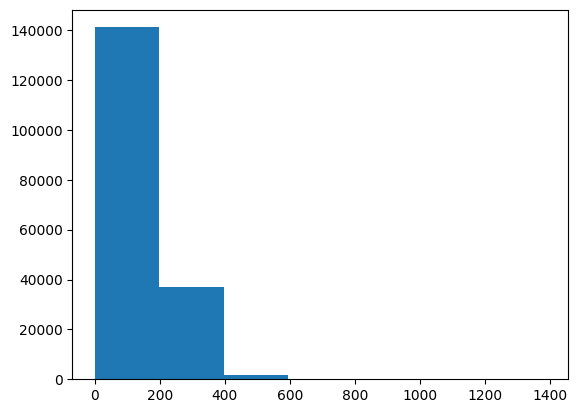

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what charcter length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most comman characters: {char_vocab[:5]}")
print(f"5 least comman characters: {char_vocab[-5]}")

Number of different characters in character vocab: 28
5 most comman characters: ['', '[UNK]', 'e', 't', 'i']
5 least comman characters: k


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 w e   a n a l y s e d   @   i n d i v i d u a l s   e n r o l l e d   i n   t h e   d i e t a r y   a p p r o a c h e s   t o   s t o p   h y p e r t e n s i o n   t r i a l   w h o   h a d   a v a i l a b l e   @ - h   s b p   d a t a   a n d   w h o   i n g e s t e d   a   c o n t r o l   d i e t   .

Length of random_train_chars: 127

Vectorized chars:
 [[20  2  5  6  5 12 19  9  2 10  4  6 10  4 21  4 10 16  5 12  9  2  6  8
   7 12 12  2 10  4  6  3 13  2 10  4  2  3  5  8 19  5 14 14  8  7  5 11
  13  2  9  3  7  9  3  7 14 13 19 14  2  8  3  2  6  9  4  7  6  3  8  4
   5 12 20 13  7 13  5 10  5 21  5  4 12  5 22 12  2 13  9 22 14 10  5  3
   5  5  6 10 20 13  7  4  6 18  2  9  3  2 10  5 11  7  6  3  8  7 12 10
   4  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0 

In [ ]:
# Create a char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 w e   a n a l y s e d   @   i n d i v i d u a l s   e n r o l l e d   i n   t h e   d i e t a r y   a p p r o a c h e s   t o   s t o p   h y p e r t e n s i o n   t r i a l   w h o   h a d   a v a i l a b l e   @ - h   s b p   d a t a   a n d   w h o   i n g e s t e d   a   c o n t r o l   d i e t   .

Embedded chars. (after vectorization and embedding):
 [[[ 0.01479029  0.02154387  0.03694129 ...  0.01818747 -0.0324388
   -0.02506839]
  [ 0.03872452 -0.0445695   0.01202061 ...  0.04291553 -0.04421041
   -0.02754475]
  [ 0.00941429  0.0476797   0.03698169 ...  0.02727312  0.03436947
    0.00657922]
  ...
  [ 0.00044299  0.01341685 -0.043765   ...  0.04469669  0.02226971
   -0.01575305]
  [ 0.00044299  0.01341685 -0.043765   ...  0.04469669  0.02226971
   -0.01575305]
  [ 0.00044299  0.01341685 -0.043765   ...  0.04469669  0.02226971
   -0.01575305]]]
Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs,
                         outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Summary
model_3.summary();

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 11ms/step - loss: 1.2685 - accuracy: 0.4953 - val_loss: 1.0437 - val_accuracy: 0.5957
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.9951 - accuracy: 0.6061 - val_loss: 0.9460 - val_accuracy: 0.6267
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9197 - accuracy: 0.6403 - val_loss: 0.8810 - val_accuracy: 0.6589


In [ ]:
# Make prediction with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 6s 6ms/step


array([[0.29446128, 0.3051917 , 0.05656041, 0.28946233, 0.05432426],
       [0.1630585 , 0.7151638 , 0.002998  , 0.09017454, 0.02860506],
       [0.08863777, 0.21358703, 0.1572762 , 0.49220353, 0.04829546],
       ...,
       [0.02415693, 0.03740592, 0.14671391, 0.02606015, 0.7656631 ],
       [0.05106811, 0.1868883 , 0.24018532, 0.17211929, 0.34973896],
       [0.33196345, 0.33890092, 0.20685825, 0.06058911, 0.0616883 ]],
      dtype=float32)

In [ ]:
# Conver prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.45081424599498,
 'precision': 0.6467370995942046,
 'recall': 0.6545081424599497,
 'f1': 0.6436227135320949}

##  Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.inputs],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")



In [ ]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

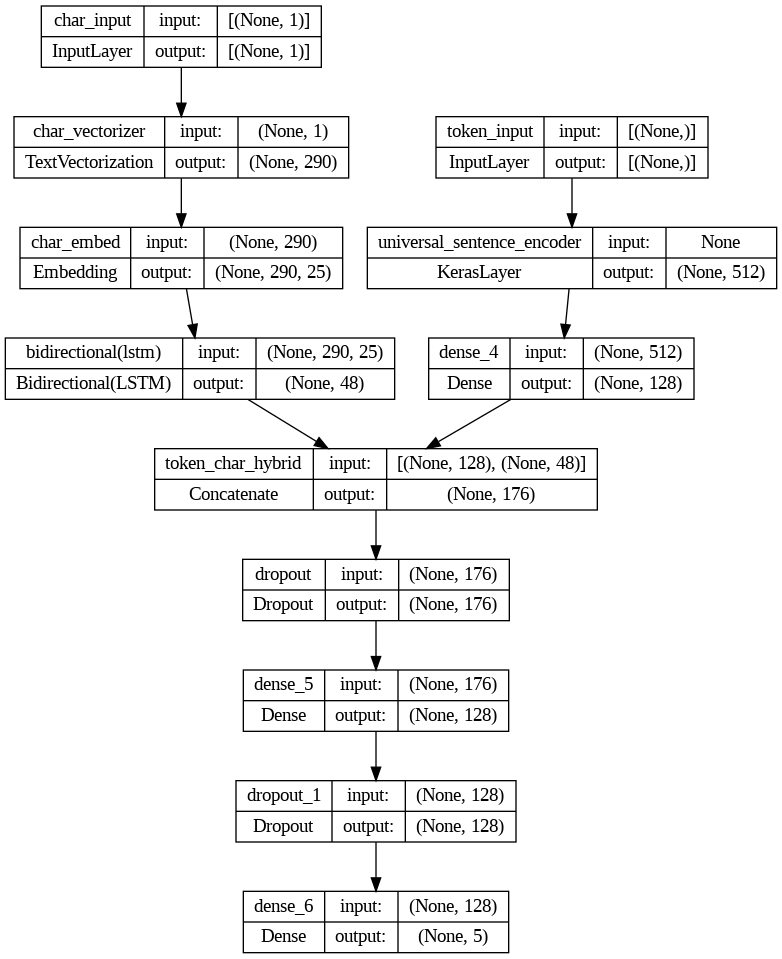

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
# combine chars and tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels))

# Prefect and bacth train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# repeat the above steps for our validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 88ms/step - loss: 0.9804 - accuracy: 0.6094 - val_loss: 0.7779 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 31s 56ms/step - loss: 0.8000 - accuracy: 0.6926 - val_loss: 0.7179 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 28s 51ms/step - loss: 0.7785 - accuracy: 0.7051 - val_loss: 0.7012 - val_accuracy: 0.7380


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 28s 30ms/step - loss: 0.7003 - accuracy: 0.7363


[0.700302243232727, 0.7362637519836426]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 42s 36ms/step


array([[3.9920282e-01, 4.0361553e-01, 5.0013559e-03, 1.8653476e-01,
        5.6454861e-03],
       [3.8513634e-01, 4.4160166e-01, 6.1467397e-03, 1.6436602e-01,
        2.7492212e-03],
       [2.5661618e-01, 7.6146513e-02, 4.5431890e-02, 6.0390830e-01,
        1.7897187e-02],
       ...,
       [6.9892633e-04, 9.8199714e-03, 6.6158757e-02, 3.3592727e-04,
        9.2298639e-01],
       [7.6834057e-03, 5.7525568e-02, 2.7552590e-01, 4.6839155e-03,
        6.5458125e-01],
       [3.8031423e-01, 2.4889554e-01, 2.8153098e-01, 4.3862998e-02,
        4.5396335e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.62637362637363,
 'precision': 0.736450044421691,
 'recall': 0.7362637362637363,
 'f1': 0.734580920139394}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

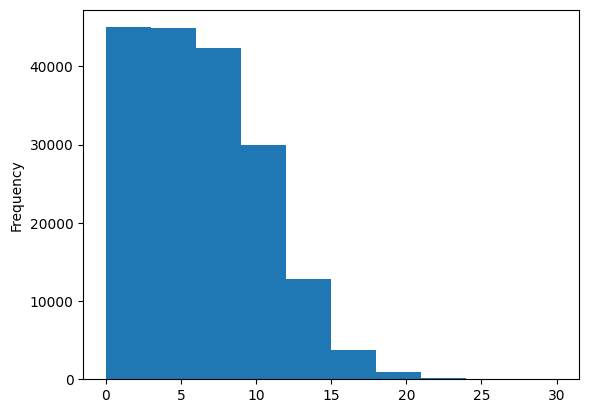

In [ ]:
# Check the distributuion of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
# How many different total lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

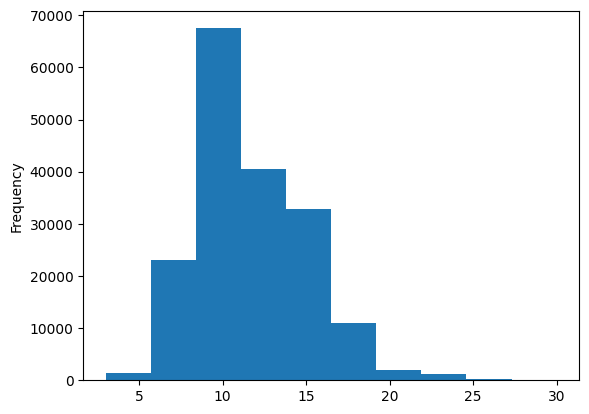

In [ ]:
# Check the distribution of "total_lines" column
train_df.total_lines.plot.hist()

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:13]

<tf.Tensor: shape=(13, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 and 5 using tf.keras.layers.Concatenate
7. Create an output layer to accpet the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Character inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
# Get a summary of our tribrid model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

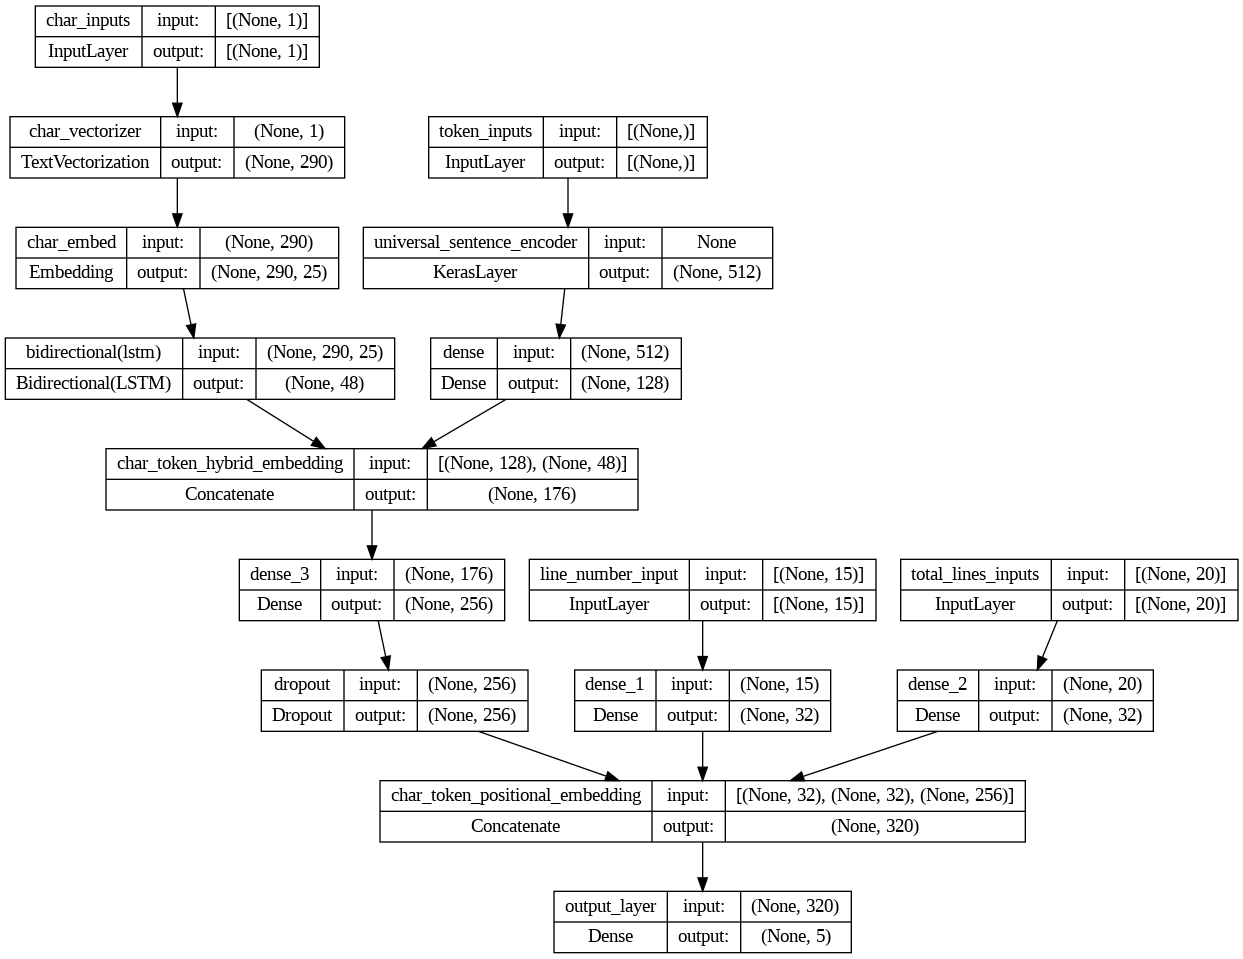

In [ ]:
# Plot model 5 to explore it visually
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?
For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully, inproving generalizations: `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [ ]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent over fitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding dataset using tf.data

In [ ]:
# Create training and validation datasets with all 4 kinds of input data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For validation dataset do the same
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 47s 56ms/step - loss: 1.1068 - accuracy: 0.7127 - val_loss: 0.9896 - val_accuracy: 0.7989
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9708 - accuracy: 0.8124 - val_loss: 0.9529 - val_accuracy: 0.8241
Epoch 3/3
562/562 [==============================] - 27s 49ms/step - loss: 0.9526 - accuracy: 0.8220 - val_loss: 0.9431 - val_accuracy: 0.8268


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 37s 32ms/step


array([[0.53465205, 0.10398387, 0.01274239, 0.32366693, 0.02495474],
       [0.5207323 , 0.11553077, 0.04371905, 0.30739474, 0.01262315],
       [0.2714273 , 0.1222739 , 0.14583926, 0.39158472, 0.06887478],
       ...,
       [0.03263154, 0.10142902, 0.04547409, 0.0260101 , 0.7944553 ],
       [0.03397891, 0.2951053 , 0.07990366, 0.02860782, 0.56240433],
       [0.19892916, 0.5568823 , 0.1260499 , 0.03585452, 0.08228409]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.03654177148154,
 'precision': 0.8293851784173987,
 'recall': 0.8303654177148153,
 'f1': 0.8295576978494265}

## Save and load model

In [ ]:
# Save the best performing model to SavedModel format (default)
model_5.save("drive/MyDrive/skimlit_tribrid_model")

In [ ]:
# Download model to machine
from google.colab import files
files.download("skimlit_tribrid_model")

In [ ]:
import tensorflow as tf
# Load in best performing model
loaded_model = tf.keras.models.load_model("drive/MyDrive/skimlit_tribrid_model")

KeyboardInterrupt: ignored

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 27s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.03654177148154,
 'precision': 0.8293851784173987,
 'recall': 0.8303654177148153,
 'f1': 0.8295576978494265}

In [ ]:
model_5_results

{'accuracy': 83.03654177148154,
 'precision': 0.8293851784173987,
 'recall': 0.8303654177148153,
 'f1': 0.8295576978494265}

In [ ]:
# Create test dataset using tf.data (fast loading)
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_pos_dataset


<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Predictions based on test dataset
loaded_test_pred_probs = loaded_model.predict(test_char_token_pos_dataset)
loaded_test_preds = tf.argmax(loaded_test_pred_probs, axis=1)
loaded_test_preds

942/942 [==============================] - 22s 24ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [ ]:
# Calculate results
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=loaded_test_preds)
loaded_model_test_results

{'accuracy': 82.64808362369338,
 'precision': 0.8253419716323375,
 'recall': 0.8264808362369338,
 'f1': 0.8256307748398111}

## Predictions on custom inputs

In [ ]:
import tensorflow as tf
# Load in best performing model
loaded_model = tf.keras.models.load_model("drive/MyDrive/skimlit_tribrid_model")

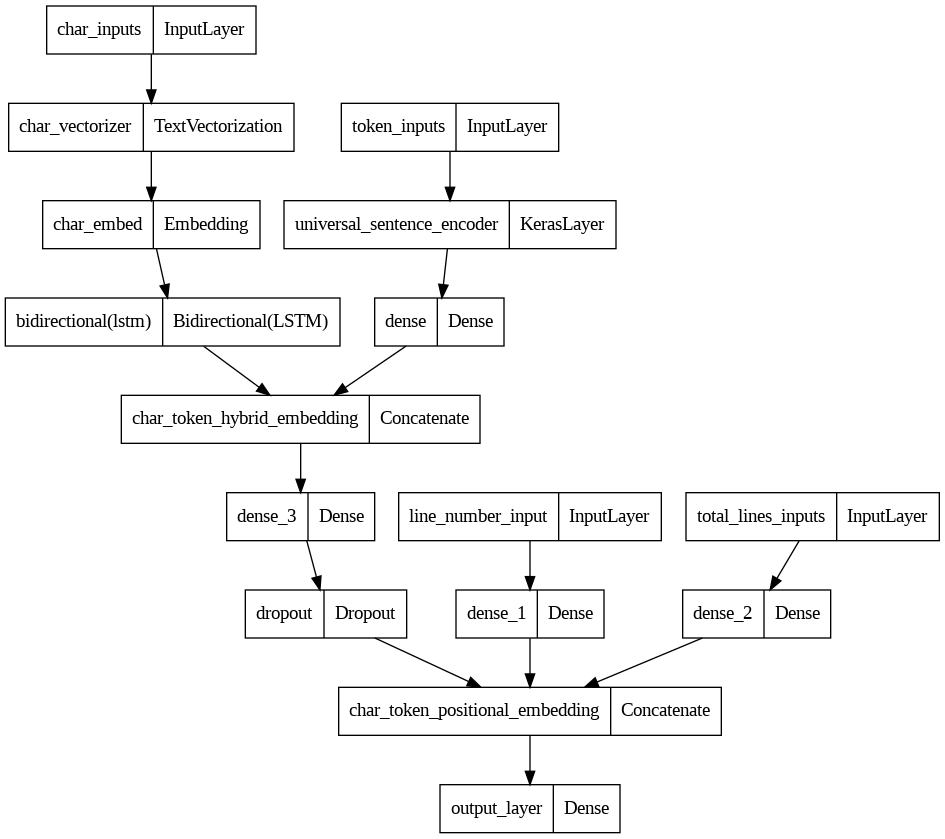

In [ ]:
from keras.utils import plot_model
plot_model(loaded_model)

In [ ]:
# Read a sample abstract
!wget https://raw.githubusercontent.com/UdityaRaj11/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2023-08-02 06:43:25--  https://raw.githubusercontent.com/UdityaRaj11/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-08-02 06:43:25 (70.2 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [ ]:
import json
f = open("skimlit_example_abstracts.json")
data = json.load(f)
print(data)

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.', 'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/', 'details': 'RCT of a manualized s

In [ ]:
import pandas as pd
pred_df = pd.DataFrame(data)
pred_df

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
pred_df["abstract"][2]
custom_pred = "Randomized controlled trials (RCTs) are considered the highest level of evidence to establish causal associations in clinical research. There are many RCT designs and features that can be selected to address a research hypothesis. Designs of RCTs have become increasingly diverse as new methods have been proposed to evaluate increasingly complex scientific hypotheses. This article reviews the principles and general concepts behind many common RCT designs and introduces newer designs that have been proposed, such as adaptive and cluster randomized trials. A focus on the many choices for randomization within an RCT is described, along with their potential tradeoffs. To illustrate their diversity, examples of RCTs from the literature are provided. Statistical considerations, such as power and type I error rates, are discussed with the intention of providing practical guidance about how to specify study hypotheses that address the scientific question while being statistically appropriate. Finally, the freely available Consolidated Standards of Reporting Trials guidelines and US Food and Drug Administration guidance documents are introduced, along with a set of guidelines one should consider when planning an RCT or reviewing RCTs submitted for publication in peer-reviewed academic journals."

In [ ]:
abstract_samples = []
abstract = custom_pred
lines = []
lines = abstract.lower().split(". ")
for line_number in range(len(lines)):
  line_data = {}
  line_data["label"] = 1 # initialize all labels as 1
  line_data["text"] = lines[line_number]
  line_data["line_number"] = line_number
  line_data["total_lines"] = len(lines)
  abstract_samples.append(line_data)

In [ ]:
pred_lines_df = pd.DataFrame(abstract_samples)
pred_sentences = pred_lines_df["text"]
pred_lines_df

,label,text,line_number,total_lines
0,1,randomized controlled trials (rcts) are consid...,0,8
1,1,there are many rct designs and features that c...,1,8
2,1,designs of rcts have become increasingly diver...,2,8
3,1,this article reviews the principles and genera...,3,8
4,1,a focus on the many choices for randomization ...,4,8
5,1,"to illustrate their diversity, examples of rct...",5,8
6,1,"statistical considerations, such as power and ...",6,8
7,1,"finally, the freely available consolidated sta...",7,8


In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# text splitting non-character-level sequence into characters
split_chars(pred_sentences[0])

'r a n d o m i z e d   c o n t r o l l e d   t r i a l s   ( r c t s )   a r e   c o n s i d e r e d   t h e   h i g h e s t   l e v e l   o f   e v i d e n c e   t o   e s t a b l i s h   c a u s a l   a s s o c i a t i o n s   i n   c l i n i c a l   r e s e a r c h'

In [ ]:
pred_chars = [split_chars(sentence) for sentence in pred_sentences]

In [ ]:
pred_line_number_one_hot = tf.one_hot(pred_lines_df["line_number"].to_numpy(), depth=15)
pred_total_lines_one_hot = tf.one_hot(pred_lines_df["total_lines"].to_numpy(), depth=20)
pred_labels_one_hot = tf.one_hot(pred_lines_df["label"].to_numpy(), depth=5)

In [ ]:
# Create final pred sentences dataset
pred_char_token_pos_data = tf.data.Dataset.from_tensor_slices((pred_line_number_one_hot,
                                                                  pred_total_lines_one_hot,
                                                                  pred_sentences,
                                                                  pred_chars))
pred_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(pred_labels_one_hot)
pred_char_token_pos_dataset = tf.data.Dataset.zip((pred_char_token_pos_data, pred_char_token_pos_labels))
pred_char_token_pos_dataset = pred_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
sample_pred_probs = loaded_model.predict(pred_char_token_pos_dataset)
sample_preds = tf.argmax(sample_pred_probs, axis=1)

1/1 [==============================] - 0s 56ms/step


In [ ]:
sample_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 0, 0, 2, 1, 4, 1, 1])>

In [ ]:
pred_lines_df["label"] = sample_preds

In [ ]:
# Extract labels ("target" columns) and decode them into strings
from sklearn.preprocessing import LabelEncoder
l = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']
label_encoder = LabelEncoder().fit(l)
pred_labels = label_encoder.inverse_transform(pred_lines_df["label"])

In [ ]:
final_output = {"OBJECTIVE":"", "BACKGROUND":"", "METHODS":"", "RESULTS":"", "CONCLUSIONS":""}
for i in range(pred_lines_df["total_lines"][0]):
  if(final_output.get(pred_labels[i]) == ""):
    final_output.update({pred_labels[i] : pred_lines_df["text"][i].capitalize()})
    continue
  final_output.update({pred_labels[i] : str(final_output.get(pred_labels[i])) + ". " + pred_lines_df["text"][i].capitalize()})
final_output

{'OBJECTIVE': '',
 'BACKGROUND': 'Randomized controlled trials (rcts) are considered the highest level of evidence to establish causal associations in clinical research. There are many rct designs and features that can be selected to address a research hypothesis. Designs of rcts have become increasingly diverse as new methods have been proposed to evaluate increasingly complex scientific hypotheses',
 'METHODS': 'This article reviews the principles and general concepts behind many common rct designs and introduces newer designs that have been proposed, such as adaptive and cluster randomized trials',
 'RESULTS': 'To illustrate their diversity, examples of rcts from the literature are provided',
 'CONCLUSIONS': 'A focus on the many choices for randomization within an rct is described, along with their potential tradeoffs. Statistical considerations, such as power and type i error rates, are discussed with the intention of providing practical guidance about how to specify study hypothes